In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f449946f-dbd6-a0a2-b16c-ed9158889b0a)


In [3]:

import tensorflow as tf
print(f"TensorFlow version:{tf.__version__}")


TensorFlow version:2.18.0


In [4]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)

  img = tf.image.decode_jpeg(img)

  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:

    return img/255.
  else:
    return img

In [5]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):


  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]


  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)


  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  threshold = (cm.max() + cm.min()) / 2.


  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

In [6]:
import tensorflow_datasets as tfds

In [7]:
datasets_list=tfds.list_builders()

target_dataset="food101"
print(f"'{target_dataset}' in TensorFlow Datasets : {target_dataset in datasets_list} ")

'food101' in TensorFlow Datasets : True 


In [8]:
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.51Z7KX_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.51Z7KX_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_one_sample=train_data.take(1)

In [12]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape} Imagee dtype: {image.dtype}
        Target class from Food101 (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3) Imagee dtype: <dtype: 'uint8'>
        Target class from Food101 (tensor form): 70
        Class name (str form): pad_thai
        


In [14]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[230, 229, 183],
        [231, 230, 184],
        [232, 231, 183],
        ...,
        [232, 233, 202],
        [229, 234, 204],
        [229, 236, 205]],

       [[228, 227, 179],
        [227, 226, 178],
        [226, 226, 176],
        ...,
        [234, 235, 204],
        [232, 237, 207],
        [234, 241, 210]],

       [[229, 229, 175],
        [229, 229, 175],
        [227, 227, 175],
        ...,
        [233, 234, 202],
        [232, 237, 205],
        [235, 242, 209]],

       ...,

       [[119,  97,  58],
        [131, 109,  70],
        [131, 109,  70],
        ...,
        [239, 241, 220],
        [238, 240, 219],
        [238, 240, 219]],

       [[120,  98,  61],
        [133, 111,  74],
        [135, 113,  76],
        ...,
        [240, 242, 221],
        [240, 242, 221],
        [240, 242, 221]],

       [[136, 114,  77],
        [135, 113,  76],
        [129, 107,  70],
        ...,
        [243, 245, 22

In [15]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

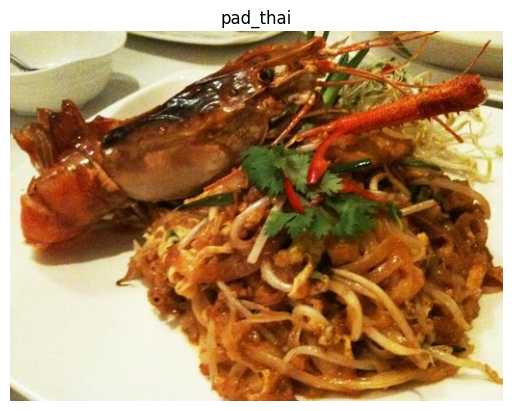

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [17]:
def preprocess_img(image,label,img_shape=224):
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label


In [18]:
preprocessed_img=preprocess_img(image,label)[0]
print(f"Image before preprocessing: \n {image[:2]}....,\nShape : {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing: \n {preprocessed_img[0:2]}....,\nShape: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]....,
Shape : (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing: 
 [[[229.46939 228.46939 181.7551 ]
  [229.59184 228.94897 180.2347 ]
  [224.14796 224.14796 171.71939]
  ...
  [238.21933 231.07143 200.37251]
  [237.02545 233.38266 204.23978]
  [230.32655 236.04091 205.68373]]

 [[228.80103 228.87245 174.58673]
  [225.95409 225.95918 173.80103]
  [226.64795 226.64795 174.21939]
  ...
  [238.41322 232.41322 199.95409]
  [235.8571  233.14287 202.07143]
  [233.04602 238.76038 206.4032 ]]]....,
Shape: <dtype: 'float32'>


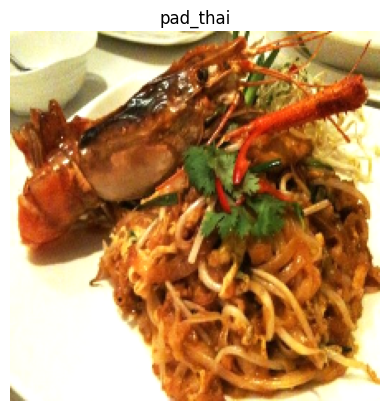

In [19]:
plt.imshow(preprocessed_img/225.)
plt.title(class_names[label])
plt.axis(False);

In [20]:
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data=test_data.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

test_data=test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [31]:
def create_tensorboard_callback(dir_name, experiment_name):
  import datetime

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [23]:


checkpoint_path="model_checkpoint/cp.ckpt.weights.h5"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_accuracy",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [25]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [26]:
from tensorflow.keras import layers

input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,name="input_layer")
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=layers.Dense(len(class_names))(x)

outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
def compare_historys(original_history, new_history, initial_epochs=5):


    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [29]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [32]:
tf.get_logger().setLevel("ERROR")

history_101_food_classes_feature_extract=model.fit(train_data,
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   callbacks=[create_tensorboard_callback("training_logs","efficientnetb0_101_classes_all_data_feature_extract"), model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250507-091105
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 210s 75ms/step - accuracy: 0.4754 - loss: 2.2912 - val_accuracy: 0.6939 - val_loss: 1.1288
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 83ms/step - accuracy: 0.6678 - loss: 1.2892 - val_accuracy: 0.7166 - val_loss: 1.0320
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 162s 66ms/step - accuracy: 0.7060 - loss: 1.1292 - val_accuracy: 0.7304 - val_loss: 0.9839


In [33]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [34]:
result_feature_extract_model=model.evaluate(test_data)
result_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.7276 - loss: 0.9966


[0.996354341506958, 0.7309703230857849]

In [35]:

def create_model():

  input_shape=(224,224,3)
  base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable=False

  inputs=layers.Input(shape=input_shape,name="input_layer")
  x=base_model(inputs,training=False)
  x=layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x=layers.Dense(len(class_names))(x)

  outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
  model=tf.keras.Model(inputs,outputs)
  return model

created_model=tf.keras.Model(inputs, outputs)
created_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

created_model.load_weights(checkpoint_path)

results_created_model_with_loaded_weights=created_model.evaluate(test_data)



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - accuracy: 0.7272 - loss: 0.9968


In [36]:
import numpy as np
assert np.isclose(result_feature_extract_model,results_created_model_with_loaded_weights).all()

In [37]:
for layer in created_model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)


input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [39]:
save_dir="07_efficientnetb0_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [40]:
loaded_saved_model=tf.keras.models.load_model(save_dir)

In [41]:
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [42]:
results_loaded_saved_model=loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 64ms/step - accuracy: 0.7273 - loss: 0.9971


[0.9963555932044983, 0.7309703230857849]

In [43]:
import numpy as np
assert np.isclose(result_feature_extract_model,results_loaded_saved_model).all()

In [44]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2025-05-07 09:24:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  12.7MB/s    in 1.3s    

2025-05-07 09:24:39 (12.7 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [45]:
!mkdir downloaded_gs_model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [60]:
import tensorflow as tf

loaded_gs_model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision.keras")



loaded_gs_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [62]:
results_loaded_gs_model=loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - accuracy: 0.7269 - loss: 0.9977


[0.9963558316230774, 0.7309703230857849]

In [63]:
for layer in loaded_gs_model.layers:
  layers.trainable=True
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [64]:
for layer in loaded_gs_model.layers[1].layers[0:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [68]:
checkpoint_path = "fine_tune_checkpoints/model_checkpoint.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss"
)


In [69]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=2,
                                               verbose=1,
                                               min_lr=1e-7)

In [70]:
loaded_gs_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001),
                        metrics=["accuracy"])

In [ ]:
history_101_food_classes_all_data_fine_tune=loaded_gs_model.fit(train_data,
                                                                epochs=100,
                                                                validation_data=test_data,
                                                                validation_steps=int(len(test_data)),
                                                                callbacks=[create_tensorboard_callback("training_logs","efficientb0_101_classes_all_data_fine_tuning"),
                                                                           model_checkpoint,
                                                                           early_stopping,
                                                                           reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20250507-094324
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 292s 112ms/step - accuracy: 0.7393 - loss: 1.0012 - val_accuracy: 0.7397 - val_loss: 0.9647 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 240s 101ms/step - accuracy: 0.7482 - loss: 0.9778 - val_accuracy: 0.7417 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 226s 85ms/step - accuracy: 0.7528 - loss: 0.9536 - val_accuracy: 0.7413 - val_loss: 0.9561 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 241s 101ms/step - accuracy: 0.7535 - loss: 0.9473 - val_accuracy: 0.7423 - val_loss: 0.9538 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 242s 101ms/step - accuracy: 0.7544 - loss: 0.9444 - val_accuracy: 0.7426 - val_loss: 0.9511 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 228s 87ms/step - accuracy: 0.7621 -

In [72]:
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_claases_mixed_precision.keras")

In [73]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2025-05-07 09:42:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  13.5MB/s    in 3.5s    

2025-05-07 09:42:42 (12.7 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [74]:
!mkdir downloaded_fine_tuned_gs_model
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [ ]:


import tensorflow as tf

loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.keras")




In [ ]:
loaded_fine_tuned_gs_model.summary()

In [ ]:
results_downloaded_fine_tuned_gs_model=loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

In [ ]:
class_names=test_data.class_names
class_names

In [ ]:
def load_and_prep_image(filename,img_shape=224,scale=True):
  img=tf.io.read_file(filename)
  img=tf.io.decode_image(img)
  img=tf.image.resize(img,[img_shape,img_shape])
  if scale:
    return img/225.
  else:
    return img

In [ ]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17,10))
for i in range(3):
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+class_name))
  filepath=test_dir+class_name+"/"+filename


  img=load_and_prep_image(filepath,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/225.)
  if class_name==pred_class:
    title_color="g"
  else:
    title_color="r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)

  plt.axis(False);

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images=["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img=load_and_prep_image(img,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]


  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False);